# EDA and Modeling Notebook

This notebook is designed for AWS Amazon SageMaker Notebook instance type (ml.t2.xlarge).

## Import Necessary Modules

Depending on your environment you may need to install a few modules.

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install wordcloud

In [ ]:
!pip install neattext

In [ ]:
import boto3
import re
import string
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
get_ipython().magic('matplotlib inline')

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer


import neattext as nt
import neattext.functions as nfx
from wordcloud import WordCloud, STOPWORDS, tokenization

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 100)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

## Read in Data

If your file is stored in an AWS s3 bucket, this is how you read in your data file. Please take a look at the link to find out more about uploading and retrieving data from an s3 bucket. 

https://docs.aws.amazon.com/AmazonS3/latest/userguide/UsingBucket.html

In [3]:
#Gather data from s3 bucket
bucketname = 'YOUR BUCKET NAME HERE'
filename = 'script_EDA_file.csv'

s3 = boto3.resource('s3')
s3.Bucket(bucketname).download_file(filename, '../../script_EDA_file.csv')

In [4]:
df = pd.read_csv("../../script_EDA_file.csv")

In [5]:
#Drop first column
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
#View data info
df.info()

## Data Cleaning

For text data, data cleaning is a very important iterative step. I used regex along with other functions to remove unneccesary characters and digits from my text column.

In [7]:
#Remove unneccesary characters from text
df['text'] = df['text'].apply(lambda x: re.sub("[^\w\d' ]", ' ', x))

In [8]:
#Split script column by words (tokenize)
df['text'] = df['text'].str.split()

In [9]:
#Create Movie title column using the text file names
df["movie_title"] = df["file_name"].apply(lambda x: x.split(".")[0].replace("_", " "))

In order to create my target columns (movie genres), I had to extract it from the bottom of each script. The following three cells is my process of pulling the text that contained the genre, putting it into a new column, and then separating them into list format (they were not previously separated). Depending on the format of your text file, you may not have to do these steps.

In [10]:
#Pull last couple of words from script to extract genre
df['Genres'] = df['text'].apply(lambda x: x[-40:])

In [11]:
# Separate Genre into a separate column

def pull_genre(column):
    newlst = []
    [newlst.append(column[i + 1]) for i, word in enumerate(column) if word == "Genres"]
    return newlst

df['genre'] = df['Genres'].apply(lambda x: pull_genre(x))

df.drop(columns = ['Genres'], axis = 1, inplace = True)

df['genre'] = df['genre'].apply(lambda x: x[0])

In [12]:
#Split Genre into Lists
def split_genres(genres):
    return re.sub( r"([A-Z])", r" \1", genres).split()

df['genre'] = df['genre'].apply(lambda x: split_genres(str(x)))

Due to the format of my raw data, I knew that all the words that were in all capital letters were either stage directions, character names, or location names. I removed capitalized words in order to clean the data, and get the text down to just the dialogue between characters in each script.

In [13]:
def remove_caps(text):
    regex = re.compile(r"(\b[A-Z]+\b)")
    caps = list(filter(regex.match, text))
    no_caps = [x for x in text if x not in caps]
    return no_caps

df['text'] = df['text'].apply(lambda x: remove_caps(x))

In [14]:
# Turn text column into strings for preprocessing purposes
df['text'] = df['text'].apply(lambda x: " ".join(x))

In [15]:
#Remove digits
def remove_digits(text):
    text = re.sub('\w*\d\w*', "", text)
    return text

df['text'] = df['text'].apply(remove_digits)

In [ ]:
#Preview data cleaning progress
df.head()

### Multi-Label Binarizer

My target data involves several labels, so I implemented the multi-label binarizer from sklearn's preprocessing library to convert my genre column into columns and assign a "1" for movies with that particular genre and a "0" for all other movies.

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

# Binarise labels
mlb = MultiLabelBinarizer()
expandedGenreData = mlb.fit_transform(df['genre'])
labelClasses = mlb.classes_


# Create a pandas.DataFrame from our output
expandedGenres = pd.DataFrame(expandedGenreData, columns=labelClasses)

In [19]:
#concat dataframes back together
df_concat = pd.concat([df, expandedGenres], axis=1)

During preprocessing the genre names with "-" were cut and so I am returning the column names back to their original form.

In [20]:
#Rename some columns
df_concat.rename(columns={'Film': 'Film-Noir', 'Sci': 'Sci-Fi'}, inplace=True)

Neattext is another library that can be used for text preprocessing. Below I am doing a bit more cleaning as well as adding custom words to my stop words list.

In [23]:
#Additional data cleaning using neattext library
def new_clean(words):
    docx = nt.TextFrame(words)
    docx.remove_stopwords(lang='en')
    docx.remove_multiple_spaces
    docx.remove_special_characters
    docx.remove_numbers
    docx.remove_puncts()
    docx.remove_custom_words(["b", "look", "s", "nt", "like", "re", "door", "know", "away", "back", 'looks', "n't", 'takes', 'right'])
    docx.remove_custom_words(['turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll', 'room', 'good', 'eyes'])
    docx.remove_custom_words(["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', 'hand', 'written', 'com', '-', '–', '—', 'come', 'take', 'got', 'head', 'hand'])
    return docx

df_concat['text'] = df_concat['text'].apply(lambda x: new_clean(x))

In [30]:
#Save data to csv along the way
# df_concat.to_csv("../../justincase.csv", index = False)

In [ ]:
#Save data to csv along the way
# df_concat.to_csv("../../no_caps_script.csv", index = False)

### Removing Stop Words

In [28]:
df = pd.read_csv("../../no_caps_script.csv")

In [31]:
# setting stopwords and punctuations
import string, re

stop_words_list = stopwords.words('english')
stop_words_list += list(string.punctuation)
stop_words_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'hand', 'written', 'com', '-', '–', '—', 'come', 'take', 'got', 'head', 'hand']
stop_words_list += ["b", "look", "s", "nt", "like", "re", "door", "know", "away", "back", 'looks', "n't", 'takes', 'right']
stop_words_list += ['turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll', 'room', 'good', 'eyes']

stop_words_set = set(stop_words_list)

In [32]:
# Define function that removes stopwords and tokenizes text column
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words_set]
    return stopwords_removed 

# applying the above function to our text column
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
# df['text'].apply(lambda x: remove_stopwords(x))

In [34]:
df.to_csv("../../no_stop_words.csv", index = False)

### Lemmitization

In [37]:
df2 = pd.read_csv("../../no_stop_words.csv")

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

In [38]:
#Delist text column for preprocessing purposes
df2['text'] = df2['text'].apply(eval).apply(' '.join)

In [41]:
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

df2['text'] = df2['text'].apply(lemmatize_text)

In [43]:
df2.to_csv('../../lemm_data.csv', index = False)

### Frequency Distribution

In [4]:
df_lemm = pd.read_csv('../../lemm_data.csv')

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

In [ ]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=5, stop_words="english")
df_cv = cv.fit_transform(df_lemm.text)
df_dtm = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_lemm.movie_title
df_dtm

In [49]:
import pickle
# Let's pickle it for later use
df_dtm.to_pickle("../../dtm.pkl")

## Visualizing Data

Below is the display of the distribution of movie scripts for each genre. There are several genres with a small amount of scripts and so they will be left out of the modeling process.

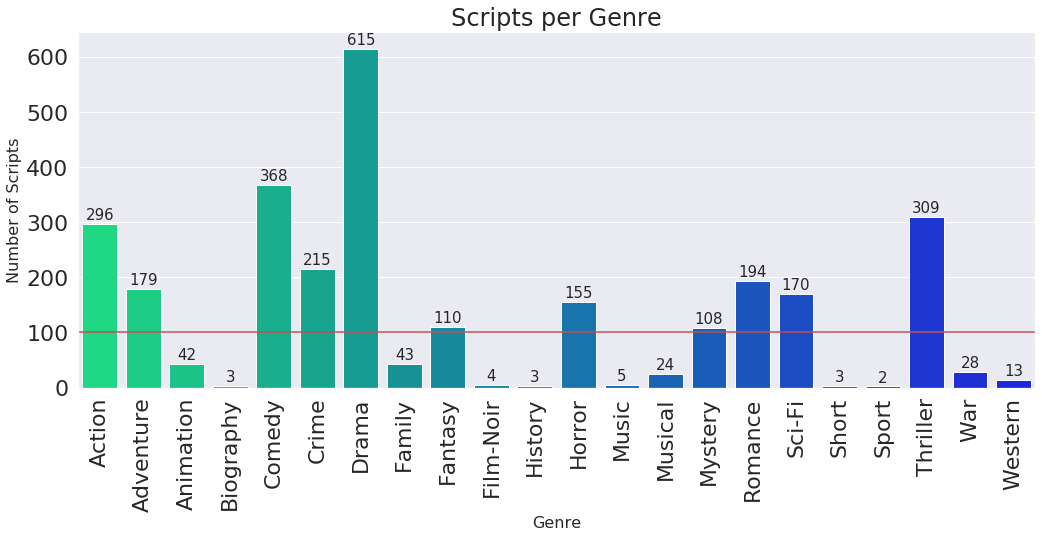

In [121]:
#Barplot for amount of scripts in each genre
categories = list(df_lemm.columns[4:].values)
sns.set(font_scale = 2, style = 'darkgrid')
plt.figure(figsize=(15,8))
color = cm.winter_r(np.linspace(.4,.8, 30))

ax= sns.barplot(categories, df_lemm.iloc[:,4:].sum().values, palette=("winter_r"))


plt.axhline(100, color = 'r')
plt.title("Scripts per Genre", fontsize=24)
plt.ylabel('Number of Scripts', fontsize=16)
plt.xlabel('Genre', fontsize=16)

ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='center')


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                size = 15,
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.savefig('../../scripts_per_genre.png')

plt.show()

Below is the display of the number of genres assigned to movies. There is one movie in my sample that has seven genres assigned to it. The majority of films in my sample have between one and four genres assigned to them.

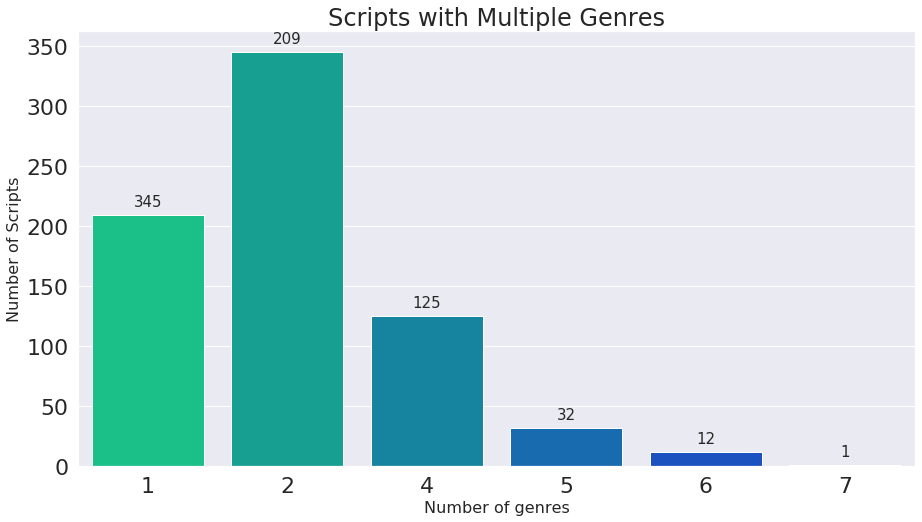

In [115]:
#Barplot for scripts that have multiple genres

rowSums = df_lemm.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2, style = 'darkgrid')
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values, palette=("winter_r"))
# ax.grid(False)

plt.title("Scripts with Multiple Genres")
plt.ylabel('Number of Scripts', fontsize=16)
plt.xlabel('Number of genres', fontsize=16)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, 
            label, ha='center', va='bottom', size=15)
    

plt.savefig('../../scripts_multiple_genre.png')

plt.show()

### Most Common Words Bar Graphs

Below is the process of creating frequency distribution for the words in the top four genres. Below is the display of which words appear the most in Drama, Comedy, Action, and Thriller movies.

In [73]:
#Setting separate dataframes for these genres
df_drama = df_lemm[df_lemm['Drama']==1]
df_comedy = df_lemm[df_lemm['Comedy']==1]
df_action = df_lemm[df_lemm['Action']==1]
df_thriller = df_lemm[df_lemm['Thriller']==1]

In [74]:
#Assigning variables to the text column for these genres
drama_text = df_drama['text']
comedy_text = df_comedy['text']
action_text = df_action['text']
thriller_text = df_thriller['text']

In [75]:
#Additional data cleaning
script_drama = list(map(new_clean, drama_text))
script_comedy = list(map(new_clean, comedy_text))
script_action = list(map(new_clean, action_text))
script_thriller = list(map(new_clean, thriller_text))

In [76]:

flat_drama = [sublist for sublist in script_drama]
flat_comedy = [sublist for sublist in script_comedy]
flat_action = [sublist for sublist in script_action]
flat_thriller = [sublist for sublist in script_thriller]

In [77]:
#tokenize text for each genre
drama_token = nltk.word_tokenize(str(flat_drama))
comedy_token = nltk.word_tokenize(str(flat_comedy))
action_token = nltk.word_tokenize(str(flat_action))
thriller_token = nltk.word_tokenize(str(flat_thriller))

In [78]:
#create frequency distribution for following genres
drama_freq = FreqDist(drama_token)
comedy_freq = FreqDist(comedy_token)
action_freq = FreqDist(action_token)
thriller_freq = FreqDist(thriller_token)

In [79]:
# Top 20 thriller words:
# thriller_freq.most_common(25)

In [80]:
# create counts of genre with values and words
drama_bar_counts = [x[1] for x in drama_freq.most_common(25)]
drama_bar_words = [x[0] for x in drama_freq.most_common(25)]

comedy_bar_counts = [x[1] for x in comedy_freq.most_common(25)]
comedy_bar_words = [x[0] for x in comedy_freq.most_common(25)]

action_bar_counts = [x[1] for x in action_freq.most_common(25)]
action_bar_words = [x[0] for x in action_freq.most_common(25)]

thriller_bar_counts = [x[1] for x in thriller_freq.most_common(25)]
thriller_bar_words = [x[0] for x in thriller_freq.most_common(25)]

In [81]:
# setting the color of our bar graphs
color = cm.winter_r(np.linspace(.4,.8, 30))

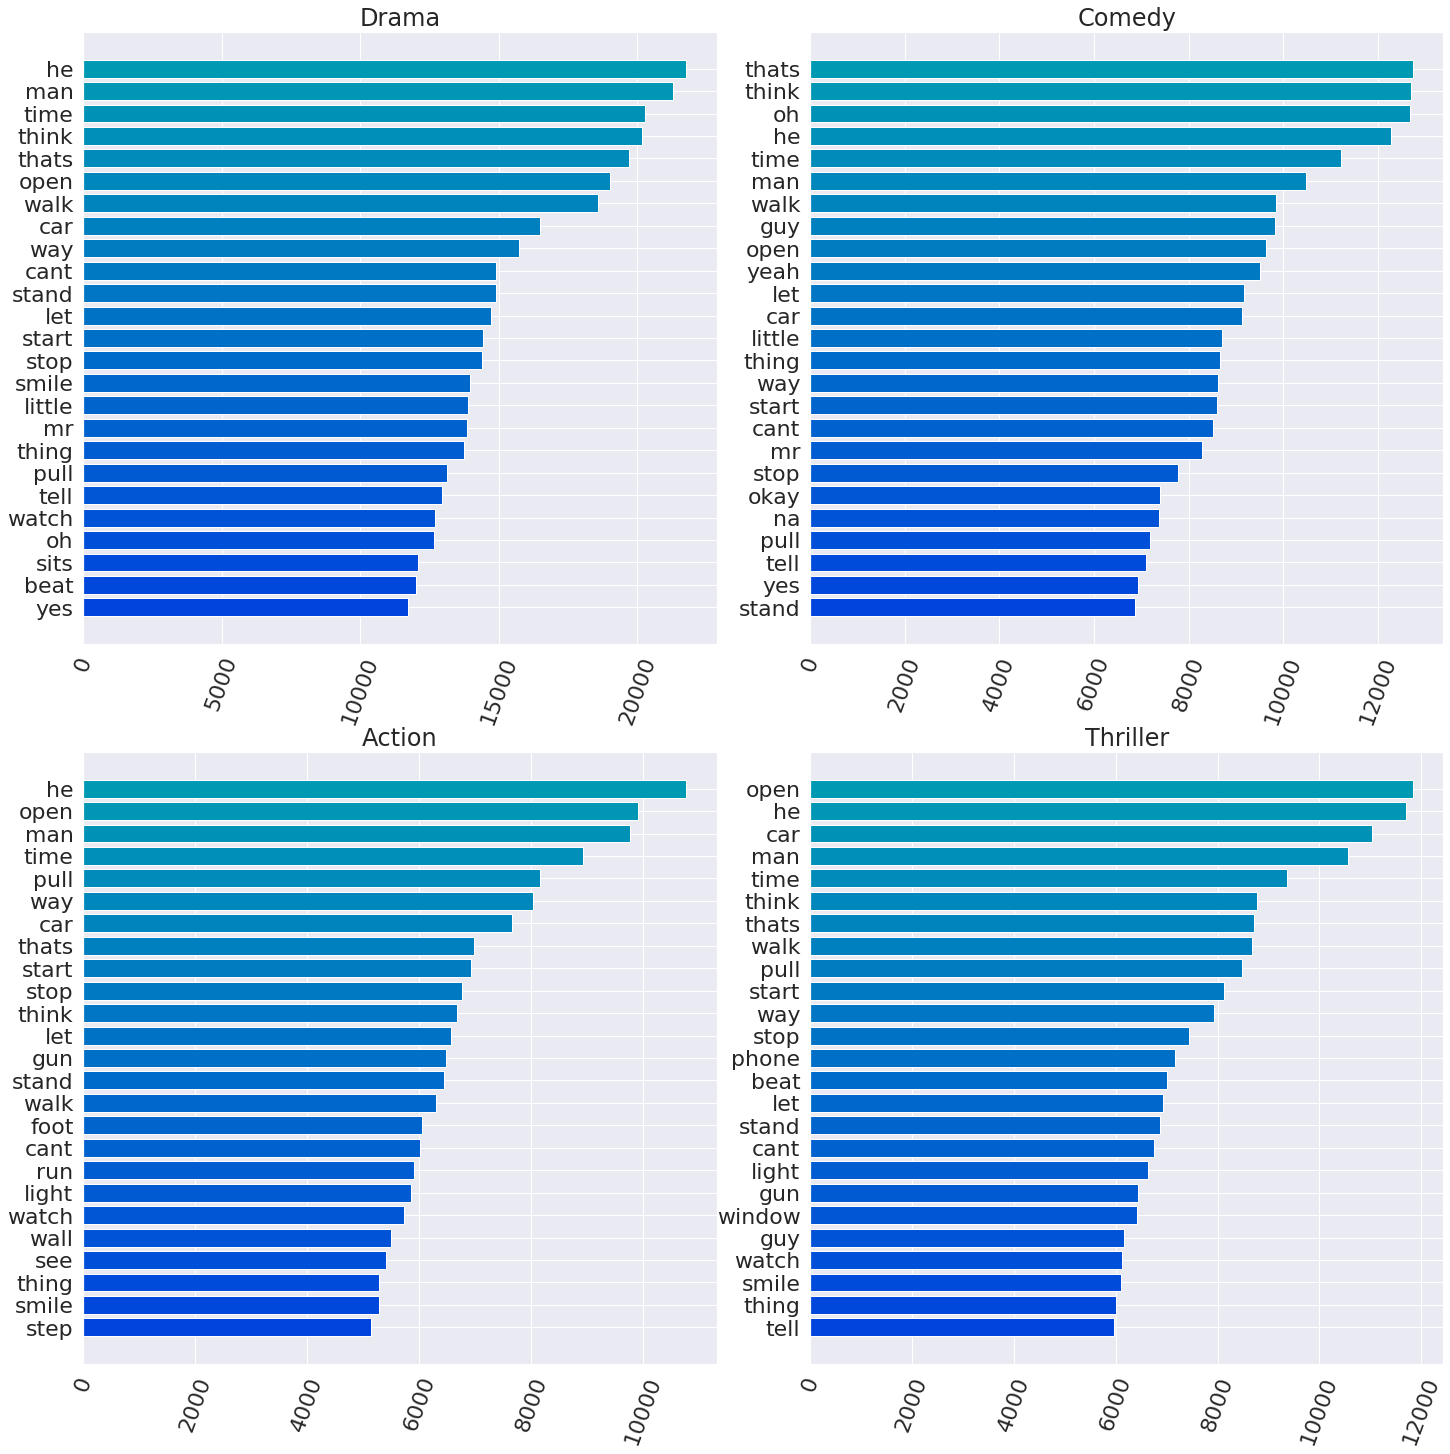

In [128]:
#Plot each graph on a different axis
new_figure = plt.figure(figsize=(20,20))

ax = new_figure.add_subplot(221)
ax2 = new_figure.add_subplot(222)
ax3 = new_figure.add_subplot(223)
ax4 = new_figure.add_subplot(224)


# Generate a line plot on first axes
ax.barh(drama_bar_words, drama_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.barh(comedy_bar_words, comedy_bar_counts, color=color)

# Draw a scatter plot on 3rd axes
ax3.barh(action_bar_words, action_bar_counts, color=color)

# Draw a scatter plot on 4th axes
ax4.barh(thriller_bar_words, thriller_bar_counts, color=color)


ax.title.set_text('Drama')
ax2.title.set_text('Comedy')
ax3.title.set_text('Action')
ax4.title.set_text('Thriller')


for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
    plt.gca().invert_yaxis()


plt.tight_layout(pad=0)

# plt.yscale()
plt.savefig('../../word_count_bar_graphs.png')
plt.show()

### Wordclouds

Another way to visualize the distribution of words in each genre is to use a word cloud. Below I create word clouds for the top six genres.

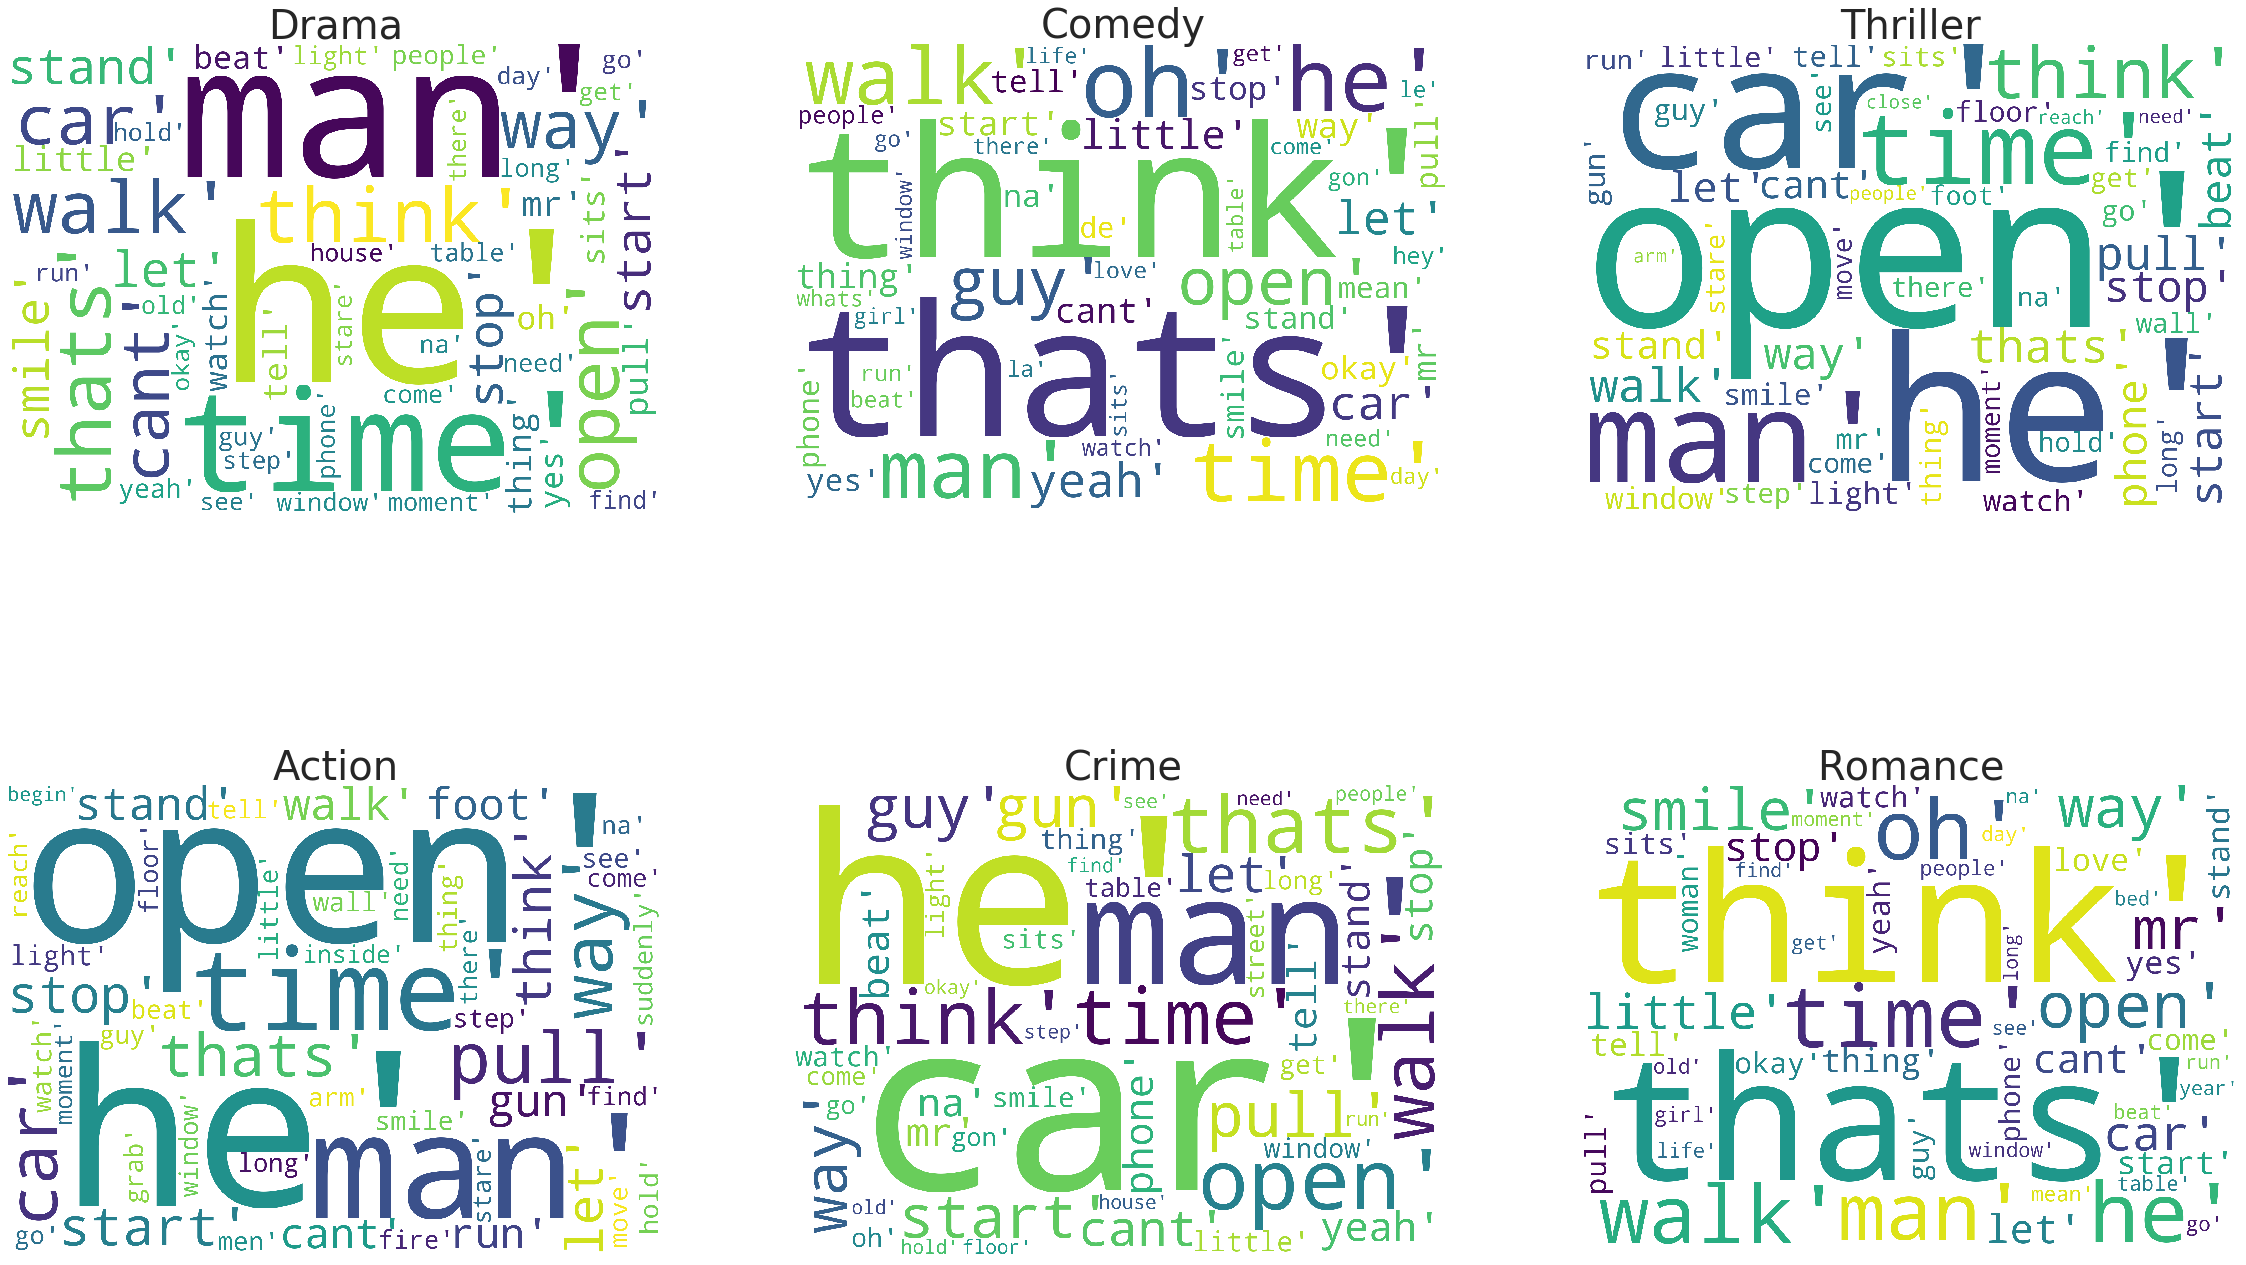

In [133]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

# drama
subset = df_lemm[df_lemm.Drama==1]
text = [line for line in subset.text.values]
cloud_drama = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        collocations=False,
                        max_words=50,
                        width=2500,
                        height=1800).generate(str(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Drama",fontsize=40)
plt.imshow(cloud_drama)


# comedy
subset = df_lemm[df_lemm.Comedy==1]
text = [line for line in subset.text.values]
cloud_comedy = WordCloud(stopwords=STOPWORDS,
                         background_color='white',
                         collocations=False,
                         max_words=50,
                         width=2500,
                         height=1800).generate(str(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Comedy",fontsize=40)
plt.imshow(cloud_comedy)



# Thriller
subset = df_lemm[df_lemm.Thriller==1]
text = [line for line in subset.text.values]
cloud_thriller = WordCloud(stopwords=STOPWORDS,
                           background_color='white',
                           collocations=False,
                           max_words=50,
                           width=2500,
                           height=1800).generate(str(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("Thriller",fontsize=40)
plt.imshow(cloud_thriller)


# action
subset = df_lemm[df_lemm.Action==1]
text = [line for line in subset.text.values]
cloud_action = WordCloud(stopwords=STOPWORDS,
                         background_color='white',
                         collocations=False,
                         max_words=50,
                         width=2500,
                         height=1800).generate(str(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Action",fontsize=40)
plt.imshow(cloud_action)


# crime
subset = df_lemm[df_lemm.Crime==1]
text = [line for line in subset.text.values]
cloud_crime = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        collocations=False,
                        max_words=50,
                        width=2500,
                        height=1800).generate(str(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Crime",fontsize=40)
plt.imshow(cloud_crime)


# romance
subset = df_lemm[df_lemm.Romance==1]
text = [line for line in subset.text.values]
cloud_romance = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          max_words=50,
                          width=2500,
                          height=1800).generate(str(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Romance",fontsize=40)
plt.imshow(cloud_romance)
plt.savefig('../../wordcloud.png')
plt.get_cmap('winter_r')
plt.show()

### Train-Test-Split

As I mentioned above, data cleaning is an iterative process. Here is minor, additional data cleaning that was done prior to modeling.

In [21]:
#Additional data cleaning
df_lemm['text'] = df_lemm['text'].apply(nfx.remove_multiple_spaces)

In [22]:
#setting variable to text column
script_corpus = df_lemm['text'].apply(nfx.clean_text)

In [23]:
#Defining X and y variable prior to train-test-split
X = script_corpus
y = df_lemm.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
#Preview the shape of training and test set
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (855,)
y_train Shape: (855, 22)
X_test Shape: (286,)
y_test Shape: (286, 22)


In [97]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df_lemm, random_state=42, test_size=0.25, shuffle=True)

# print("Train Shape:", train.shape)
# print("Test Shape:", test.shape)

In [19]:
# train_text = train['text']
# test_text = test['text']

### TF-IDF

After train-test-split, I vectorize my train and test set and proceed with modeling.

In [26]:
tfidf = TfidfVectorizer(ngram_range=(1,3))

tfidf_train_lem = tfidf.fit_transform(X_train)
tfidf_test_lem = tfidf.transform(X_test)

tfidf_train_lem

<855x11797036 sparse matrix of type '<class 'numpy.float64'>'
	with 16686215 stored elements in Compressed Sparse Row format>

In [27]:
non_zero_cols = tfidf_train_lem.nnz / float(tfidf_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 19516.040935672514
Percentage of columns containing ZERO: 0.998345682683712


In [59]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2', stop_words=stop_words_set)
# vectorizer.fit(train_text)
# vectorizer.fit(test_text)

In [21]:
# X_train = vectorizer.transform(train_text)
# y_train = train.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

# X_test = vectorizer.transform(test_text)
# y_test = test.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

### Baseline Accuracy for each Category

Instead of training models to predict on all of the movie genres avaiable, there are some whose sample size is too small to provide any insight so I am only training models to predict on the genres that have at least 100 movies in their category.

In [153]:
#Setting categories for top eleven genres
categories = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
print(categories)

['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']


Here I am viewing what baseline accuracy would look like for each genre. Below you can also view some class imbalance in a handful of the genre categories.

In [45]:
#View value counts to measure baseline accuracy
for category in categories:
    print('Normalized Value Count for {} Scripts'.format(category))
    print(y[category].value_counts(normalize=True))
    print("\n")

Normalized Value Count for Action Scripts
0    0.740578
1    0.259422
Name: Action, dtype: float64


Normalized Value Count for Adventure Scripts
0    0.84312
1    0.15688
Name: Adventure, dtype: float64


Normalized Value Count for Comedy Scripts
0    0.677476
1    0.322524
Name: Comedy, dtype: float64


Normalized Value Count for Crime Scripts
0    0.811569
1    0.188431
Name: Crime, dtype: float64


Normalized Value Count for Drama Scripts
1    0.539001
0    0.460999
Name: Drama, dtype: float64


Normalized Value Count for Fantasy Scripts
0    0.903593
1    0.096407
Name: Fantasy, dtype: float64


Normalized Value Count for Horror Scripts
0    0.864154
1    0.135846
Name: Horror, dtype: float64


Normalized Value Count for Mystery Scripts
0    0.905346
1    0.094654
Name: Mystery, dtype: float64


Normalized Value Count for Romance Scripts
0    0.829974
1    0.170026
Name: Romance, dtype: float64


Normalized Value Count for Sci-Fi Scripts
0    0.851008
1    0.148992
Name: Sci-Fi, d

## Modeling

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier

### Logistic Regression Pipeline

In [36]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting logistic regression model on train data
    LogReg_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # predict on test set
    LR_prediction = LogReg_pipeline.predict(tfidf_test_lem)
    
    # calculating test accuracy
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], LR_prediction)))
    print('F1 score is {}'.format(f1_score(y_test[category], LR_prediction)))
    print("\n")

Processing Action scripts
Testing accuracy is 0.7412587412587412
F1 score is 0.0


Processing Adventure scripts
Testing accuracy is 0.8601398601398601
F1 score is 0.0


Processing Comedy scripts
Testing accuracy is 0.6573426573426573
F1 score is 0.05769230769230769


Processing Crime scripts
Testing accuracy is 0.7902097902097902
F1 score is 0.0


Processing Drama scripts
Testing accuracy is 0.6783216783216783
F1 score is 0.75


Processing Fantasy scripts
Testing accuracy is 0.8951048951048951
F1 score is 0.0


Processing Horror scripts
Testing accuracy is 0.8566433566433567
F1 score is 0.0


Processing Mystery scripts
Testing accuracy is 0.9090909090909091
F1 score is 0.0


Processing Romance scripts
Testing accuracy is 0.8146853146853147
F1 score is 0.0


Processing Sci-Fi scripts
Testing accuracy is 0.8671328671328671
F1 score is 0.0


Processing Thriller scripts
Testing accuracy is 0.7167832167832168
F1 score is 0.0


CPU times: user 2.69 s, sys: 2.94 s, total: 5.64 s
Wall time: 7m

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    return fig

### Linear Support Vector Classifier

In [42]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(), n_jobs= -1))])

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting logistic regression model on train data
    SVC_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # predict on test set
    SVC_prediction = SVC_pipeline.predict(tfidf_test_lem)
    
    # calculating test accuracy
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], SVC_prediction)))
    print('F1 score is {}'.format(f1_score(y_test[category], SVC_prediction)))
    print("\n")

Processing Action scripts
Testing accuracy is 0.7867132867132867
F1 score is 0.34408602150537637


Processing Adventure scripts
Testing accuracy is 0.8811188811188811
F1 score is 0.29166666666666663


Processing Comedy scripts
Testing accuracy is 0.7202797202797203
F1 score is 0.4202898550724638


Processing Crime scripts
Testing accuracy is 0.7902097902097902
F1 score is 0.11764705882352941


Processing Drama scripts
Testing accuracy is 0.6573426573426573
F1 score is 0.7030303030303031


Processing Fantasy scripts
Testing accuracy is 0.9020979020979021
F1 score is 0.125


Processing Horror scripts
Testing accuracy is 0.8741258741258742
F1 score is 0.25


Processing Mystery scripts
Testing accuracy is 0.9055944055944056
F1 score is 0.0


Processing Romance scripts
Testing accuracy is 0.8076923076923077
F1 score is 0.06779661016949153


Processing Sci-Fi scripts
Testing accuracy is 0.9090909090909091
F1 score is 0.4799999999999999


Processing Thriller scripts
Testing accuracy is 0.7062

### Multinomial Naive Bayes Pipeline

In [155]:
%%time

# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB()))])


for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting Naive Bayes model on train data
    NB_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # predict on test set
    NB_prediction = NB_pipeline.predict(tfidf_test_lem)
    
    # calculating test accuracy
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], NB_prediction)))
    print('F1 score is {}'.format(f1_score(y_test[category], NB_prediction)))
    print("\n")

Processing Action scripts
Testing accuracy is 0.7412587412587412
F1 score is 0.0


Processing Adventure scripts
Testing accuracy is 0.8601398601398601
F1 score is 0.0


Processing Comedy scripts
Testing accuracy is 0.6503496503496503
F1 score is 0.0


Processing Crime scripts
Testing accuracy is 0.7902097902097902
F1 score is 0.0


Processing Drama scripts
Testing accuracy is 0.6363636363636364
F1 score is 0.761467889908257


Processing Fantasy scripts
Testing accuracy is 0.8951048951048951
F1 score is 0.0


Processing Horror scripts
Testing accuracy is 0.8566433566433567
F1 score is 0.0


Processing Mystery scripts
Testing accuracy is 0.9090909090909091
F1 score is 0.0


Processing Romance scripts
Testing accuracy is 0.8146853146853147
F1 score is 0.0


Processing Sci-Fi scripts
Testing accuracy is 0.8671328671328671
F1 score is 0.0


Processing Thriller scripts
Testing accuracy is 0.7167832167832168
F1 score is 0.0


CPU times: user 16.9 s, sys: 4.24 s, total: 21.1 s
Wall time: 21.1 

In [150]:
NB_prediction.

(286,)

In [157]:
y_pred_proba = NB_pipeline.predict_proba(tfidf_test_lem)

In [158]:
y_pred_proba

array([[9.96635184e-01, 3.36481621e-03],
       [9.69806844e-01, 3.01931564e-02],
       [9.76314280e-01, 2.36857196e-02],
       [9.85538361e-01, 1.44616387e-02],
       [9.84261400e-01, 1.57385996e-02],
       [9.71684141e-01, 2.83158588e-02],
       [9.99538787e-01, 4.61213325e-04],
       [9.71942790e-01, 2.80572096e-02],
       [9.97507744e-01, 2.49225618e-03],
       [9.83228086e-01, 1.67719138e-02],
       [9.81610178e-01, 1.83898222e-02],
       [9.90100669e-01, 9.89933116e-03],
       [9.93648490e-01, 6.35151015e-03],
       [9.99811431e-01, 1.88569167e-04],
       [9.61606538e-01, 3.83934618e-02],
       [9.50700678e-01, 4.92993220e-02],
       [9.96610273e-01, 3.38972685e-03],
       [9.88776752e-01, 1.12232484e-02],
       [9.98823910e-01, 1.17608995e-03],
       [9.97096322e-01, 2.90367803e-03],
       [9.98769717e-01, 1.23028264e-03],
       [9.73714648e-01, 2.62853521e-02],
       [9.83270700e-01, 1.67293004e-02],
       [9.90439255e-01, 9.56074493e-03],
       [9.988872

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(rounded_ylabels, NB_prediction)
mat
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=['Satire', 'Not_Satire'], yticklabels=['Satire', 'Not_Satire'])
# plt.xlabel('true label')
# plt.ylabel('predicted label');

TypeError: Singleton array 0 cannot be considered a valid collection.

### Gaussian Naive Bayes

In [33]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 1.3 MB/s eta 0:00:011


In [34]:
%%time

# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
GNB = BinaryRelevance(GaussianNB())


#Fitting Naive Bayes model on train data
GNB.fit(tfidf_train_lem.toarray(), y_train)
    
# # predict on test set
# prediction = GNB.predict(tfidf_test_lem)
    
# # calculating test accuracy
# print('Testing accuracy is {}'.format(accuracy_score(y_test, prediction)))


# for category in categories:
#     print('Processing {} scripts'.format(category))
    
#     # Fitting Naive Bayes model on train data
#     GNB.fit(tfidf_train_lem, y_train[category])
    
#     # predict on test set
#     prediction = GNB.predict(tfidf_test_lem)
    
#     # calculating test accuracy
#     print('Testing accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
#     print("\n")

MemoryError: Unable to allocate 75.2 GiB for an array with shape (855, 11797036) and data type float64